In [1]:
import pandas as pd
import glob
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees

### Loading  Data

In [2]:
train_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Original Data\\train.csv")
test_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Original Data\\test.csv")

### Functions to concatenate features, kfold splits

In [3]:
def feature_concat(train_data1,filepath):
    for file in filepath:
        data_features = pd.read_csv(file)
        train_data1=pd.merge(train_data1,data_features,how='left',on='card_id')
    return(train_data1)

In [4]:
def kfold_split(splitcount,train_data1,ignore_cols):  
    output_feature=['target']
    input_features=[x for x in train_data1.columns if x not in ['first_active_month', 'card_id','target','target_bin','month_max']]
    train_X = train_data1[input_features]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    train_X = train_X.select_dtypes(include=numerics)
    train_y = train_data1[output_feature]
    kf = StratifiedKFold(n_splits=splitcount, random_state=2018, shuffle=True)
    counter=0
    models=[]
    splits={}
    for dev_index, val_index in kf.split(train_X,train_data1['target_bin']):
        dev_X, val_X = train_X.loc[dev_index, :], train_X.loc[val_index, :]
        dev_y, val_y = train_y.loc[dev_index], train_y.loc[val_index]
        splits[counter] = [dev_X, val_X,dev_y, val_y]
        counter=counter+1
    return splits

### Concatenate features

In [7]:
%%time
file_list=glob.glob("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\faetures_feb18th\\*.csv")
train_features=feature_concat(train_data, file_list)

Wall time: 1min 6s


In [8]:
train_features.shape

(201917, 318)

### Binning target variable

In [9]:
# Binning the numeric variable to different categories
target_std=train_features['target'].std()
max_target=train_features['target'].max()+1
min_target=train_features['target'].min()-1
bins=[min_target,-3*target_std,-2*target_std,-1*target_std,target_std*1,target_std*2,target_std*3,max_target]
labels=[-4,-3,-2,0,2,3,5]
train_features['target_bin']=pd.cut(train_features['target'],bins=bins,labels=labels).astype(int)
train_features['target_bin']=train_features['target_bin'].abs()
train_features.groupby(['target_bin']).size()

target_bin
0    191093
2      8200
3       363
4      2237
5        24
dtype: int64

### KFold Splits

In [10]:
kfolds=kfold_split(5,train_features,['first_active_month', 'card_id','target','target_bin','month_max'])

### XGBoost

In [11]:
# xgb_model = xgb.XGBRegressor(booster='gbtree',nthread=2,learning_rate=0.01,max_depth=10,min_child_weight=177,subsample=0.8)
param={'nthread':2,'learning_rate':0.01,'max_depth':10,'min_child_weight':177,'subsample':0.8,
       'num_boost_round':2000,'early_stopping_rounds':200,'verbose_eval':100,'eval_metric':'rmse','obj':'reg:linear'}

# xgb_model = xgb.XGBRegressor(booster='gbtree',nthread=2,learning_rate=0.01,max_depth=14,min_child_weight=100,subsample=0.7)
# xgb_model = xgb.XGBRegressor(booster='gblinear',reg_lambda=0.7,reg_alpha =0.3)
models=[]
for split in kfolds.keys():
    dtrain = xgb.DMatrix(kfolds[split][0].values, label=kfolds[split][2].values)
    dvalid = xgb.DMatrix(kfolds[split][1].values, label=kfolds[split][3].values)
    evallist = [(dvalid, 'eval'), (dtrain, 'train')]
    xgb.train(params=param,evals=evallist,dtrain=dtrain)
#     xgb_model.(kfolds[split][0].values,kfolds[split][2].values)
    models.append(xgb_model)
    break

[0]	eval-rmse:3.94306	train-rmse:3.94823
[1]	eval-rmse:3.93789	train-rmse:3.9425
[2]	eval-rmse:3.93313	train-rmse:3.93709
[3]	eval-rmse:3.92847	train-rmse:3.93173
[4]	eval-rmse:3.92358	train-rmse:3.92622
[5]	eval-rmse:3.91887	train-rmse:3.92083
[6]	eval-rmse:3.91428	train-rmse:3.9157
[7]	eval-rmse:3.90971	train-rmse:3.91055
[8]	eval-rmse:3.90522	train-rmse:3.90545
[9]	eval-rmse:3.90094	train-rmse:3.90046


NameError: name 'xgb_model' is not defined

In [47]:
# xgb_model = xgb.XGBRegressor(booster='gbtree',nthread=2,learning_rate=0.01,max_depth=10,min_child_weight=177,subsample=0.8)
predictions=xgb.predict(kfolds[split][1].values)
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(predictions, kfolds[split][3]))
# 3.7116724208480183

AttributeError: module 'xgboost' has no attribute 'predict'

In [29]:
# xgb_model = xgb.XGBRegressor(booster='gbtree',nthread=2,learning_rate=0.01,max_depth=14,min_child_weight=177,subsample=0.7)
predictions=xgb_model.predict(kfolds[split][1].values)
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(predictions, kfolds[split][3]))

3.709588043708955

In [39]:
pd.DataFrame(xgb_model.feature_importances_,kfolds[split][0].columns).sort_values(0,ascending=False)

,0
pa_diff,0.044988
purchase_amount1_max_y,0.030352
ref_first,0.029230
month_max_x,0.026236
ref_last,0.025862
time_diff_future,0.024822
purchase_amount_<lambda>_x,0.023741
amount_perc,0.021745
purchase_amount1_var_y,0.019874
purchase_amount_max_x,0.018253


In [31]:
pd.DataFrame(xgb_model.feature_importances_,kfolds[split][0].columns).sort_values(0,ascending=False)

,0
purchase_amount1_max_y,0.040706
ref_first,0.025634
purchase_amount_mean_y,0.023649
amount_perc,0.022914
time_diff_future,0.022669
purchase_amount1_mean_y,0.020733
purchase_amount_max_x,0.020537
purchase_amount_<lambda>_x,0.020047
purchase_amount1_var_y,0.020047
ref_last,0.019924


In [72]:
kfolds[split][2]

,target
0,-0.820283
1,0.392913
2,0.688056
4,-0.159749
6,0.230129
7,2.135850
8,-0.065406
9,0.300062
10,-1.029562
11,-2.433761


### LGBM

In [14]:
def run_lgb(train_X, train_y, val_X, val_y):
    param = {'num_leaves': 30,
             'min_data_in_leaf': 30,
             'objective': 'regression',
             'max_depth': 9,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.7,
             "bagging_freq": 5,
             "bagging_fraction": 0.7,
             "bagging_seed": 11,
             "metric": 'rmse',
             # "lambda_l1": 0.2634,
             "random_state": 133,
             "verbosity": -1}

    lgtrain = lgb.Dataset(train_X, label = y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(param, lgtrain, 2000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100,
                      evals_result=evals_result)
    return model, evals_result

In [15]:
model, evals_result=run_lgb(kfolds[split][0],kfolds[split][2], kfolds[split][1], kfolds[split][3])

AttributeError: 'DataFrame' object has no attribute 'ravel'

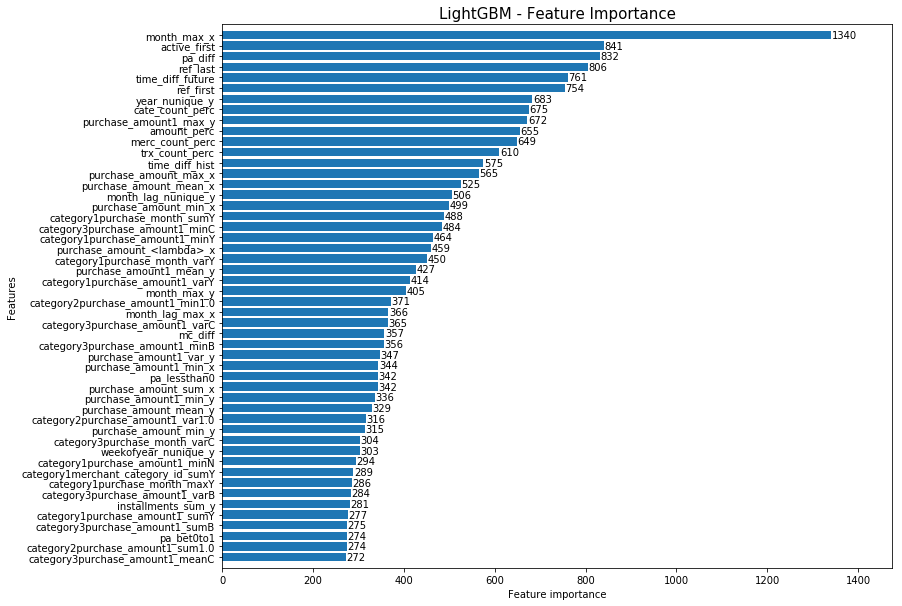

In [50]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Distribution Check after split

In [23]:
train_features['target'].quantile([0,0.01,0.05,0.1,0.9,0.95,0.99,1])

0.00   -33.219281
0.01   -33.219281
0.05    -3.107836
0.10    -2.042294
0.90     1.830280
0.95     2.702680
0.99     4.812662
1.00    17.965068
Name: target, dtype: float64

In [26]:
train_features.groupby(['target_bin']).agg({'target':['mean','max','min','count']})

target                              
                 mean        max        min   count
target_bin                                         
0           -0.021767   3.849897  -3.850328  191093
2           -0.186748   7.696367  -7.700420    8200
3           -1.032952  11.542822 -11.526988     363
4          -32.965977 -11.555068 -33.219281    2237
5           13.703566  17.965068  11.553597      24

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(train_features, train_features['target_bin'], test_size=0.2, random_state=1000)

In [36]:
X_train.groupby(['target_bin']).agg({'target':['mean','max','min','count']})

target                              
                 mean        max        min   count
target_bin                                         
0           -0.023543   3.849897  -3.850328  152843
2           -0.180506   7.696367  -7.699650    6604
3           -1.435378  11.542822 -11.526988     292
4          -32.988540 -11.555068 -33.219281    1777
5           13.805608  17.965068  11.553597      17

In [37]:
X_valid.groupby(['target_bin']).agg({'target':['mean','max','min','count']})

target                             
                 mean        max        min  count
target_bin                                        
0           -0.014673   3.849492  -3.850293  38250
2           -0.212576   7.691796  -7.700420   1596
3            0.622097  11.333782 -11.359914     71
4          -32.878813 -11.801587 -33.219281    460
5           13.455750  17.675716  11.759035      7

In [33]:
X_train['target'].quantile([x*0.01 for x in range(0,101)])

0.0   -33.219281
0.1    -2.039933
0.2    -1.147356
0.3    -0.665273
0.4    -0.314507
0.5    -0.024237
0.6     0.235006
0.7     0.563472
0.8     1.012213
0.9     1.827461
Name: target, dtype: float64

In [45]:
pd.concat([X_train['target'].quantile([x*0.01 for x in range(0,101)]),X_valid['target'].quantile([x*0.01 for x in range(0,101)])],axis=1)

,target,target
0.00,-33.219281,-33.219281
0.01,-33.219281,-33.219281
0.02,-5.020796,-5.002304
0.03,-4.064584,-4.051911
0.04,-3.499662,-3.471129
0.05,-3.105053,-3.119270
0.06,-2.805674,-2.815580
0.07,-2.565359,-2.551614
0.08,-2.365682,-2.347645
0.09,-2.194724,-2.187364


In [27]:
train_features['target'].quantile([x*0.01 for x in range(0,100)])

0.00   -33.219281
0.01   -33.219281
0.02    -5.016077
0.03    -4.063205
0.04    -3.493656
0.05    -3.107836
0.06    -2.808085
0.07    -2.562565
0.08    -2.362260
0.09    -2.193361
0.10    -2.042294
0.11    -1.905758
0.12    -1.790429
0.13    -1.684038
0.14    -1.590949
0.15    -1.503916
0.16    -1.421549
0.17    -1.345709
0.18    -1.276070
0.19    -1.208162
0.20    -1.146041
0.21    -1.086996
0.22    -1.031403
0.23    -0.981558
0.24    -0.931534
0.25    -0.883110
0.26    -0.835807
0.27    -0.790561
0.28    -0.746567
0.29    -0.704465
          ...    
0.70     0.564508
0.71     0.601416
0.72     0.640400
0.73     0.680626
0.74     0.721551
0.75     0.765453
0.76     0.812274
0.77     0.859641
0.78     0.910884
0.79     0.964222
0.80     1.014255
0.81     1.071739
0.82     1.132274
0.83     1.197546
0.84     1.268989
0.85     1.345208
0.86     1.425072
0.87     1.512289
0.88     1.606397
0.89     1.712569
0.90     1.830280
0.91     1.959254
0.92     2.106803
0.93     2.283435
0.94     2